In [1]:
import pandas as pd
import numpy as np 
import math
import sys

from scipy.stats import pearsonr
import matplotlib.pyplot as plt 

import importlib
import smlmodule

from itertools import combinations
from pprint import pprint

"""
https://bmjopen.bmj.com/content/10/9/e039338

We have computed the number of COVID-19 infected people for each province and the infection 
rate based on the number of inhabitants from February 24th to March 13th (the date when the 
lockdown was decided), as reported by the official government website, updated with daily 
frequency.34 The number of PM exceedances were computed between February 9th and February 29th, 
as we had to take into account the maximum lag period of 14 days, which is the average time 
elapsed between the contagion and the first weeks of the Italian epidemic 
(February 24th to March 13th). 

period1 = ['2020-02-09', '2020-02-28'] # YEAR-MONTH-DAY --->>> CASI COVID ['2020-02-24', '2020-03-13']

period2 = ['2020-02-09', '2020-03-06] # YEAR-MONTH-DAY --->>> CASI COVID ['2020-02-09', '2020-03-21']
period3 = ['2020-08-29', '2020-09-01'] # YEAR-MONTH-DAY --->>> CASI COVID ['2020-09-12', '2020-10-15']
period4 = ['2020-08-29', '2020-10-30'] # YEAR-MONTH-DAY --->>> CASI COVID ['2020-09-12', '2020-11-14']
period5 = ['2020-05-15', '2020-08-15'] # YEAR-MONTH-DAY --->>> CASI COVID ['2020-06-01', '2020-09-01']
"""


LIMIT = 0.95

verbose = False
paperpath = "./data/particulate.csv"
agefeatspath = "./data/provinceages.csv"
deprividxpath = "./data/ID11_prov21.xlsx"
tabellecodicipath = "./data/TabelleCodici.xlsx"
copernicopath = "./data/name_region_province_statistics_2020.csv"

__provmaps__ = {
    "bolzano_bozen": "bolzano",
    "bolzanobozen": "bolzano",
    "vibovalentia": "vibo_valentia",
    "laquila": "l_aquila",
    "laspezia": "la_spezia",
    "barlettaandriatrani": "bat",
    "ascolipiceno": "ascoli_piceno",
    "carboniaiglesias": "carbonia",
    "reggioemilia": "reggio_nell_emilia",
    "pesarourbino": "pesaro",
    "monzabrianza": "monza",
    "reggiocalabria": "reggio_di_calabria",
    "forlicesena": "forli",
    "massacarrara": "massa",
    "verbanocusioossola": "verbania",
    "verbano_cusio_ossola": "verbania",
    "massa_carrara": "massa",
    "monza_e_della_brianza": "monza",
    "pesaro_e_urbino": "pesaro",
    "forli__cesena": "forli",
    "bolzano_/_bozen": "bolzano",
    "barletta_andria_trani": "bat",
    "sud_sardegna": "carbonia",
    "forlì_cesena": "forli"
}

pollutantsnames = "avg_wco_period1_2020,"+\
        "avg_wnh3_period1_2020,"+\
        "avg_wnmvoc_period1_2020,"+\
        "avg_wno2_period1_2020,"+\
        "avg_wno_period1_2020,"+\
        "avg_wo3_period1_2020,"+\
        "avg_wpans_period1_2020,"+\
        "avg_wpm10_period1_2020,"+\
        "avg_wpm2p5_period1_2020,"+\
        "avg_wso2_period1_2020," +\
        "sum_wnh3_ex_q75_period1_2020," +\
        "sum_wnmvoc_ex_q75_period1_2020," +\
        "sum_wno2_ex_q75_period1_2020," +\
        "sum_wno_ex_q75_period1_2020," +\
        "sum_wpans_ex_q75_period1_2020," +\
        "sum_wpm10_ex_q75_period1_2020," +\
        "sum_wpm2p5_ex_q75_period1_2020," +\
        "sum_wo3_ex_q75_period1_2020," + \
        "sum_wco_ex_q75_period1_2020," + \
        "sum_wso2_ex_q75_period1_2020"

featurestobeused = "density," + \
        "commutersdensity," + \
        "depriv," + \
        "lat," + \
        "Ratio0200ver65," + \
        "sum_wpm10_ex_q75_period1_2020,"+\
        "sum_wpm2p5_ex_q75_period1_2020,"+\
        "sum_wco_ex_q75_period1_2020,"+\
        "sum_wnh3_ex_q75_period1_2020,"+\
        "sum_wnmvoc_ex_q75_period1_2020,"+\
        "sum_wno2_ex_q75_period1_2020,"+\
        "sum_wno_ex_q75_period1_2020,"+\
        "sum_wo3_ex_q75_period1_2020,"+\
        "sum_wpans_ex_q75_period1_2020,"+\
        "sum_wso2_ex_q75_period1_2020"

def filterprovname (inprov):
    low = inprov.lower()
    low = low.rstrip()
    low = low.lstrip()
    low = low.replace(" ", "_")
    low = low.replace("'", "_")
    low = low.replace("-", "_")

    return low

def normalize_provname (indata, provcolumn, verbose):

    dict_data = {}  
    for c in indata.columns:
        if verbose:
            print("  ", c)
        if c != provcolumn:
            dict_data[c] = []
    dict_data["prov"] = []

    for i, row in indata.iterrows():
        for c in indata.columns:    
            if c != provcolumn:
                dict_data[c].append(row[c])
            else:
                low = filterprovname(row[c])
                if low in __provmaps__:
                    low = __provmaps__[low]

                dict_data["prov"].append(low)

    #for v in dict_data:
    #    print(v, " ", len(dict_data[v]))

    data = pd.DataFrame.from_dict(dict_data)

    return data

In [2]:
tc = pd.ExcelFile(tabellecodicipath)

idtoprov = {}
province = tc.parse("Codice Provincia")
for val in province[["Codice Provincia","Nome Provincia"]].values:
    if type(val[1]) != float:
        idtoprov[int(val[0])] = val[1]
        #print(int(val[0]), val[1])

in_datapaper = pd.read_csv(paperpath, sep=";")
in_deprividx =  pd.ExcelFile(deprividxpath).parse("Foglio1")
in_agefeatures = pd.read_csv(agefeatspath)
in_agefeatures = in_agefeatures[in_agefeatures.Population2020 != 0.0]
in_copernico = pd.read_csv(copernicopath)

print("Paper data ")
datapaper = normalize_provname(in_datapaper, "Province", False)
print("Age features ")
agefeatures = normalize_provname(in_agefeatures, "Provincia", False)
print("Copernico data ") 
copernico = normalize_provname(in_copernico, "nome_ita", False)

dict_deprividx = {}
print("DrepivIdx name ")
for c in in_deprividx.columns:
    if verbose:
        print("   ", c)   
    dict_deprividx[c] = []
dict_deprividx["prov"] = []

for i, row in in_deprividx.iterrows():
    id = row["prov21"]
    prov = filterprovname(idtoprov[id])
    
    if prov in __provmaps__:
        prov = __provmaps__[prov]
    
    #print(id, prov)
    dict_deprividx["prov"].append(prov)
    for c in in_deprividx.columns:
        dict_deprividx[c].append(row[c])


deprividx = pd.DataFrame.from_dict(dict_deprividx)       

provincelist = list(set(list(datapaper["prov"].values)) & \
        set(list(deprividx["prov"].values)) & \
        set(list(agefeatures["prov"].values)) &
        set(list(copernico["prov"].values)))

print("Province list: ")
for i, p in enumerate(provincelist):
    print("  ", i+1, " ", p)

Paper data 
Age features 
Copernico data 
DrepivIdx name 
Province list: 
   1   genova
   2   roma
   3   piacenza
   4   lodi
   5   udine
   6   cagliari
   7   parma
   8   siracusa
   9   vicenza
   10   cremona
   11   latina
   12   vercelli
   13   reggio_di_calabria
   14   matera
   15   fermo
   16   verona
   17   enna
   18   grosseto
   19   catania
   20   perugia
   21   catanzaro
   22   vibo_valentia
   23   ravenna
   24   como
   25   firenze
   26   verbania
   27   frosinone
   28   l_aquila
   29   bat
   30   savona
   31   campobasso
   32   agrigento
   33   messina
   34   foggia
   35   pavia
   36   reggio_nell_emilia
   37   napoli
   38   gorizia
   39   pordenone
   40   trento
   41   livorno
   42   padova
   43   forli
   44   massa
   45   torino
   46   varese
   47   palermo
   48   novara
   49   treviso
   50   caserta
   51   trapani
   52   ferrara
   53   arezzo
   54   oristano
   55   bergamo
   56   nuoro
   57   carbonia
   58   pisa
   59

In [3]:
counter = 0

for prov in provincelist:
    cases = datapaper[datapaper["prov"] == prov]["Cases"].values[0]
    popolazione = datapaper[datapaper["prov"] == prov]["Population"].values[0]
    pop2 = agefeatures[agefeatures["prov"] == prov]["Population2020"].values[0]
    diff = 100.0*(math.fabs(popolazione-pop2)/(popolazione))

    # check Exceedances/StationsNum
    Exceedances = datapaper[datapaper["prov"] == prov]["Exceedances"].values[0] 
    StationsNum = datapaper[datapaper["prov"] == prov]["StationsNum"].values[0] 

    #if diff < 5.0 :
    #if cases > 0.0 and diff < 5.0 and StationsNum > 0:
    if cases > 0.0 and diff < 5.0:
        counter += 1
        print(counter, prov)

ylogpropcasi = []
features_dict = {}

for fn in ("population", "density", "commutersdensity", "depriv", \
    "lat", "Ratio0200ver65","exoverstation"):
    features_dict[fn] = np.zeros(counter, dtype="float64")

for fn in pollutantsnames.split(","):
    features_dict[fn] = np.zeros(counter, dtype="float64")

i = 0 
for idx, prov in enumerate(provincelist):

    cases = datapaper[datapaper["prov"] == prov]["Cases"].values[0]
    popolazione = datapaper[datapaper["prov"] == prov]["Population"].values[0]
    pop2 = agefeatures[agefeatures["prov"] == prov]["Population2020"].values[0]

    diff = 100.0*(math.fabs(popolazione-pop2)/(popolazione))

    # check Exceedances/StationsNum
    Exceedances = datapaper[datapaper["prov"] == prov]["Exceedances"].values[0] 
    StationsNum = datapaper[datapaper["prov"] == prov]["StationsNum"].values[0] 
    
    ycasi = cases/popolazione

    #if diff < 5.0:
    #if cases > 0.0 and diff < 5.0 and StationsNum > 0:
    if cases > 0.0 and diff < 5.0:
        if ycasi == 0.0:
           ylogpropcasi.append(-13.0) 
        else:
            ylogpropcasi.append(math.log(ycasi)) # atural logarithm of different numbers

        selected = copernico[copernico["prov"] == prov]

        features_dict["population"][i] = popolazione
        features_dict["density"][i] = \
                    datapaper[datapaper["prov"] == prov]["Density"].values[0]    
        features_dict["commutersdensity"][i] = \
                    datapaper[datapaper["prov"] == prov]["CommutersDensity"].values[0]       
        features_dict["lat"][i] = \
                    datapaper[datapaper["prov"] == prov]["Lat"].values[0]       
        features_dict["depriv"][i] = \
                    deprividx[deprividx["prov"] == prov]["ID_2011"].values[0]
        #print(idx, prov, agefeatures[agefeatures["prov"] == prov])
        features_dict["Ratio0200ver65"][i] = \
                    agefeatures[agefeatures["prov"] == prov]["Ratio0200ver65"].values[0]

        for fn in pollutantsnames.split(","):
            val = selected[fn].values[0]
            features_dict[fn][i] = val 

        #features_dict["exoverstation"][i] = Exceedances/StationsNum


        i = i + 1

1 genova
2 roma
3 piacenza
4 lodi
5 udine
6 cagliari
7 parma
8 siracusa
9 vicenza
10 cremona
11 latina
12 vercelli
13 reggio_di_calabria
14 matera
15 fermo
16 verona
17 enna
18 grosseto
19 catania
20 perugia
21 catanzaro
22 vibo_valentia
23 ravenna
24 como
25 firenze
26 verbania
27 frosinone
28 l_aquila
29 bat
30 savona
31 campobasso
32 agrigento
33 messina
34 foggia
35 pavia
36 reggio_nell_emilia
37 napoli
38 gorizia
39 pordenone
40 trento
41 livorno
42 padova
43 forli
44 massa
45 torino
46 varese
47 palermo
48 novara
49 treviso
50 caserta
51 trapani
52 ferrara
53 arezzo
54 oristano
55 bergamo
56 nuoro
57 pisa
58 rimini
59 sassari
60 belluno
61 trieste
62 milano
63 ancona
64 pesaro
65 alessandria
66 prato
67 crotone
68 lecce
69 imperia
70 benevento
71 bologna
72 cuneo
73 bolzano
74 salerno
75 biella
76 rovigo
77 lecco
78 asti
79 siena
80 mantova
81 sondrio
82 rieti
83 brindisi
84 taranto
85 bari
86 brescia
87 monza
88 ascoli_piceno
89 la_spezia
90 lucca
91 venezia
92 potenza
93 caltan

In [4]:
# nomalize values
new_features_dict = {}
for fn in features_dict:
    #print(fn)
    abs_max = np.amax(np.abs(features_dict[fn]))
    if abs_max == 0.0:
        print (fn, " will be removed ")
        print (features_dict[fn])
    else:
        new_features_dict[fn] = features_dict[fn] * (1.0 / abs_max)

features_dict = new_features_dict

highcorrelated = {}
for i1, v1 in enumerate(features_dict):
    highcorrelated[v1] = []
    for i2, v2 in enumerate(features_dict):
        #if v1 != v2 and i2 > i1:
        if v1 != v2:
            corr, _ = pearsonr(features_dict[v1], features_dict[v2])
            if math.fabs(corr) > LIMIT:
                highcorrelated[v1].append(v2)
                #print(v1, v2, corr)

    #if len(highcorrelated[v1]) > 0:
    #    print(v1)
    #    for fntr in highcorrelated[v1]:
    #        print("   ", fntr)

removedfeatures = []
features = []
for fn in featurestobeused.split(","):
    if fn in features_dict:
        canadd = True
        for fnin in features:
            if fn in highcorrelated[fnin]:
                canadd = False
                break

        if canadd:
            print("Using: %30s"%fn)
            features.append(fn)
        else:
            removedfeatures.append(fn)


print("")
for fn in removedfeatures:
    print("Highly correlated removing %30s"%fn)
    for cf  in highcorrelated[fn]:
        print("     ",cf)
print(" ")

exoverstation  will be removed 
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]
sum_wo3_ex_q75_period1_2020  will be removed 
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]
sum_wco_ex_q75_period1_2020  will be removed 
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0.

Training set average RMSE:  0.35787  0.02207 
    Test set average RMSE:  0.95358  0.09796 
Parameters used: 
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}
             Fullset RMSE:  0.34435
                       R2:  0.94574


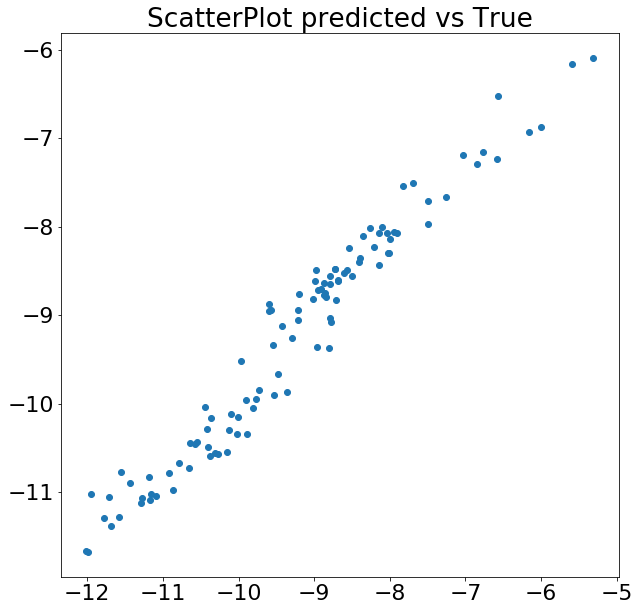

<Figure size 720x720 with 0 Axes>


Features importance from model: 
Feature:                        density, Score: 0.04974
Feature:               commutersdensity, Score: 0.03047
Feature:                         depriv, Score: 0.05701
Feature:                            lat, Score: 0.68928
Feature:                 Ratio0200ver65, Score: 0.07997
Feature:  sum_wpm10_ex_q75_period1_2020, Score: 0.01294
Feature:   sum_wnh3_ex_q75_period1_2020, Score: 0.00958
Feature: sum_wnmvoc_ex_q75_period1_2020, Score: 0.00683
Feature:   sum_wno2_ex_q75_period1_2020, Score: 0.01129
Feature:    sum_wno_ex_q75_period1_2020, Score: 0.02294
Feature:  sum_wpans_ex_q75_period1_2020, Score: 0.02400
Feature:   sum_wso2_ex_q75_period1_2020, Score: 0.00595


<Figure size 432x288 with 0 Axes>

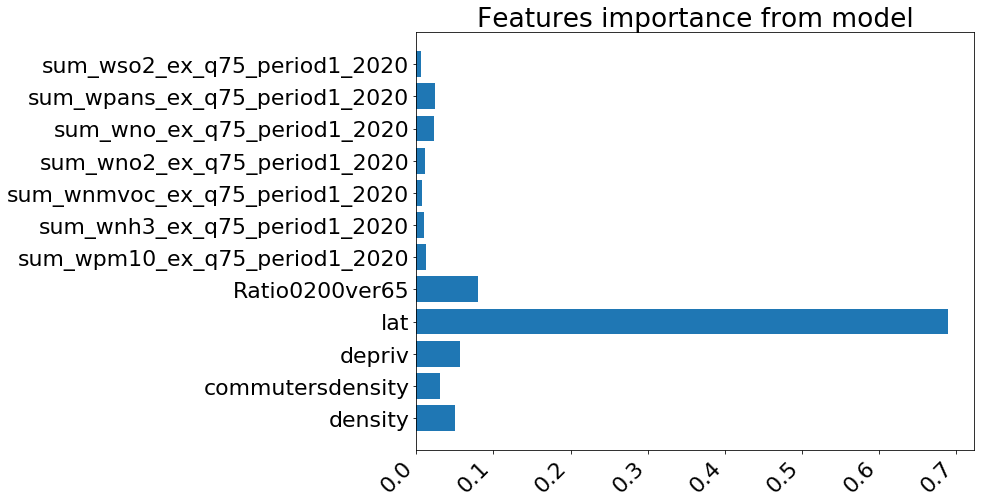

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Score neg_mean_squared_error : 
Feature:                        density, Score: 0.11598 +/- 0.01348
Feature:               commutersdensity, Score: 0.07022 +/- 0.00854
Feature:                         depriv, Score: 0.13671 +/- 0.01244
Feature:                            lat, Score: 3.35582 +/- 0.42890
Feature:                 Ratio0200ver65, Score: 0.22653 +/- 0.03120
Feature:  sum_wpm10_ex_q75_period1_2020, Score: 0.02396 +/- 0.00369
Feature:   sum_wnh3_ex_q75_period1_2020, Score: 0.01851 +/- 0.00443
Feature: sum_wnmvoc_ex_q75_period1_2020, Score: 0.01490 +/- 0.00264
Feature:   sum_wno2_ex_q75_period1_2020, Score: 0.01225 +/- 0.00133
Feature:    sum_wno_ex_q75_period1_2020, Score: 0.08560 +/- 0.01635
Feature:  sum_wpans_ex_q75_period1_2020, Score: 0.05108 +/- 0.01100
Feature:   sum_wso2_ex_q75_period1_2020, Score: 0.01529 +/- 0.00260


<Figure size 432x288 with 0 Axes>

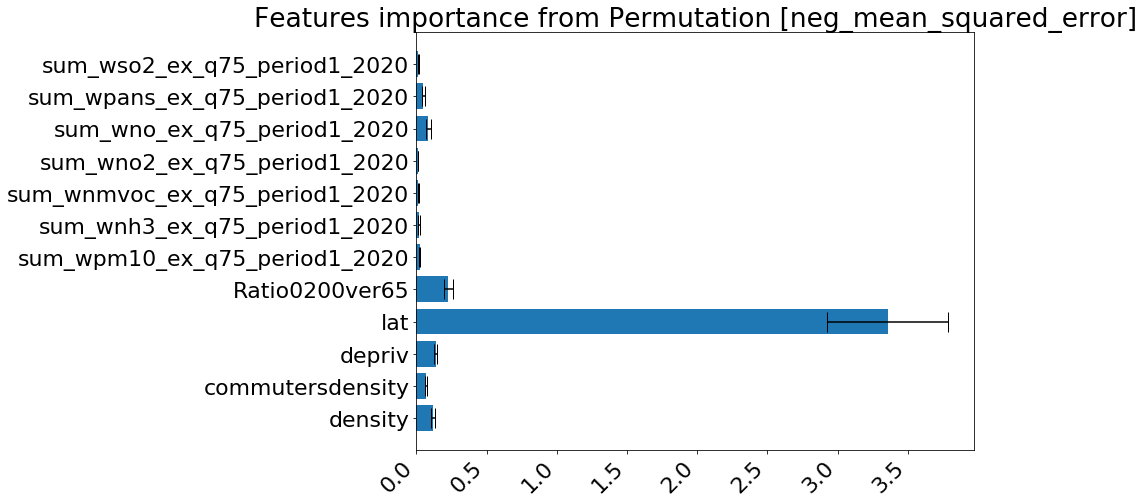

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Score r2: 
Feature:                        density, Score: 0.05307 +/- 0.00617
Feature:               commutersdensity, Score: 0.03213 +/- 0.00391
Feature:                         depriv, Score: 0.06256 +/- 0.00569
Feature:                            lat, Score: 1.53567 +/- 0.19627
Feature:                 Ratio0200ver65, Score: 0.10366 +/- 0.01428
Feature:  sum_wpm10_ex_q75_period1_2020, Score: 0.01097 +/- 0.00169
Feature:   sum_wnh3_ex_q75_period1_2020, Score: 0.00847 +/- 0.00203
Feature: sum_wnmvoc_ex_q75_period1_2020, Score: 0.00682 +/- 0.00121
Feature:   sum_wno2_ex_q75_period1_2020, Score: 0.00561 +/- 0.00061
Feature:    sum_wno_ex_q75_period1_2020, Score: 0.03917 +/- 0.00748
Feature:  sum_wpans_ex_q75_period1_2020, Score: 0.02338 +/- 0.00504
Feature:   sum_wso2_ex_q75_period1_2020, Score: 0.00700 +/- 0.00119


<Figure size 432x288 with 0 Axes>

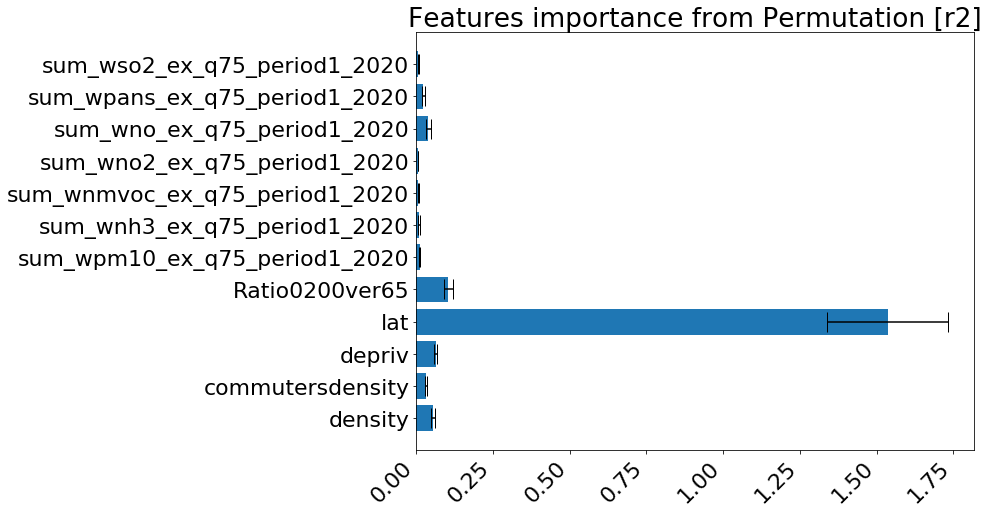

<Figure size 720x720 with 0 Axes>

((0.3578675442643643, 0.022067749202469823),
 (0.9535808248843115, 0.09795519643305918),
 0.3443471685517972,
 {'density': 0.028102585695014295,
  'commutersdensity': 0.017015764274165235,
  'depriv': 0.03312614029683011,
  'lat': 0.8131669575121954,
  'Ratio0200ver65': 0.05489101557095437,
  'sum_wpm10_ex_q75_period1_2020': 0.00580677502127623,
  'sum_wnh3_ex_q75_period1_2020': 0.004486289657014835,
  'sum_wnmvoc_ex_q75_period1_2020': 0.003611453002368533,
  'sum_wno2_ex_q75_period1_2020': 0.002968414758671894,
  'sum_wno_ex_q75_period1_2020': 0.020741600460877307,
  'sum_wpans_ex_q75_period1_2020': 0.012378000809603653,
  'sum_wso2_ex_q75_period1_2020': 0.0037050029410282603},
 {'density': 0.0281025856950143,
  'commutersdensity': 0.01701576427416524,
  'depriv': 0.033126140296830114,
  'lat': 0.8131669575121956,
  'Ratio0200ver65': 0.054891015570954375,
  'sum_wpm10_ex_q75_period1_2020': 0.005806775021276233,
  'sum_wnh3_ex_q75_period1_2020': 0.004486289657014842,
  'sum_wnmvoc_ex_q

In [5]:
#finalfeaturestobeused = "density,commutersdensity,exoverstation"
#features = finalfeaturestobeused.split(",")
#listostack = [features_dict[v] for v in features]

featuresused = features

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

plt.figure(figsize=(10,10))
smlmodule.rfregressors (X, Y , featuresused, N=50, plotname="rf_model_allfeatures_using_sum", pout=sys.stdout, showplot=True)

In [6]:
importlib.reload(smlmodule)

featuresused = features

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

bestf, bestmse = smlmodule.rfregressors_custom_optimizer (X, Y, inboot=[True])

print(bestf, bestmse)

1  of  1200 MSE:  0.11857497248963983
2  of  1200 MSE:  0.12048791709944959
3  of  1200 MSE:  0.19913847216128316
4  of  1200 MSE:  0.29427758347671207
5  of  1200 MSE:  0.44273485725127154
6  of  1200 MSE:  0.5713150354835052
7  of  1200 MSE:  0.606223149633385
8  of  1200 MSE:  0.7240089015500903
9  of  1200 MSE:  0.18375123445619582
10  of  1200 MSE:  0.2527706329784795
11  of  1200 MSE:  0.22077068185910004
12  of  1200 MSE:  0.325788938300076
13  of  1200 MSE:  0.44273485725127154
14  of  1200 MSE:  0.5713150354835052
15  of  1200 MSE:  0.606223149633385
16  of  1200 MSE:  0.7240089015500903
17  of  1200 MSE:  0.33232549635185854
18  of  1200 MSE:  0.43933876691285206
19  of  1200 MSE:  0.3573270961195467
20  of  1200 MSE:  0.4754349549202377
21  of  1200 MSE:  0.44273485725127154
22  of  1200 MSE:  0.5713150354835052
23  of  1200 MSE:  0.606223149633385
24  of  1200 MSE:  0.7240089015500903
25  of  1200 MSE:  0.44744621785072514
26  of  1200 MSE:  0.5458547993595487
27  of  1200 

{'bootstrap': True,
 'max_depth': None,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 1200,
 'random_state': 1}
Training set average RMSE:  0.35034  0.02006 
    Test set average RMSE:  0.94855  0.09510 
Parameters used: 
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 1200,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}
             Fullset RMSE:  0.34037
                       R2:  0.94698


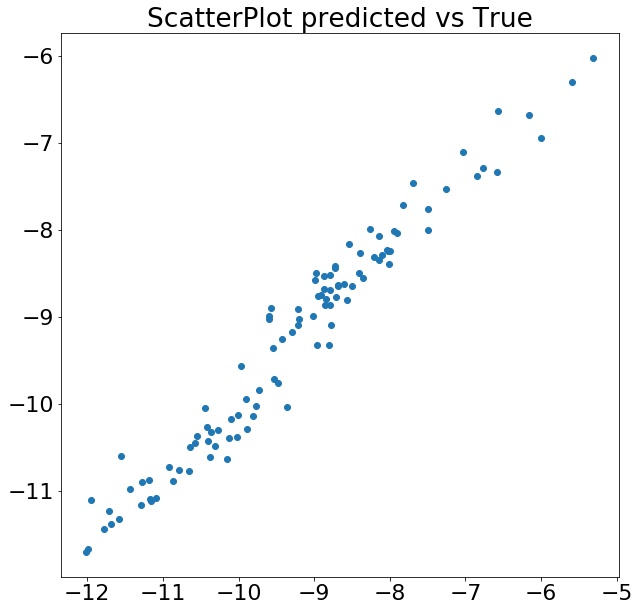

<Figure size 720x720 with 0 Axes>


Features importance from model: 
Feature:                        density, Score: 0.05936
Feature:               commutersdensity, Score: 0.17375
Feature:                         depriv, Score: 0.10481
Feature:                            lat, Score: 0.25650
Feature:                 Ratio0200ver65, Score: 0.07630
Feature:  sum_wpm10_ex_q75_period1_2020, Score: 0.04483
Feature:   sum_wnh3_ex_q75_period1_2020, Score: 0.06557
Feature: sum_wnmvoc_ex_q75_period1_2020, Score: 0.07496
Feature:   sum_wno2_ex_q75_period1_2020, Score: 0.08165
Feature:    sum_wno_ex_q75_period1_2020, Score: 0.01987
Feature:  sum_wpans_ex_q75_period1_2020, Score: 0.02203
Feature:   sum_wso2_ex_q75_period1_2020, Score: 0.02038


<Figure size 432x288 with 0 Axes>

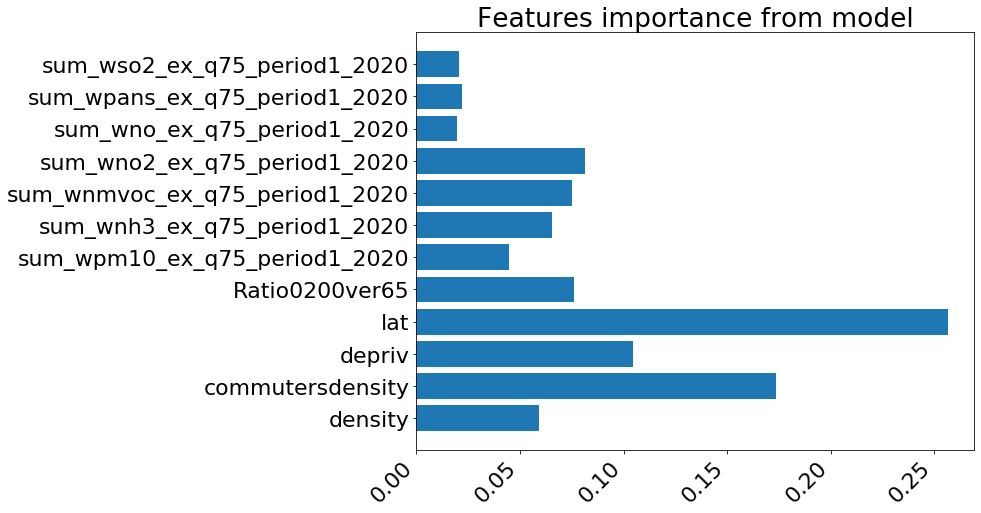

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Score neg_mean_squared_error : 
Feature:                        density, Score: 0.09846 +/- 0.01231
Feature:               commutersdensity, Score: 0.08429 +/- 0.01051
Feature:                         depriv, Score: 0.13437 +/- 0.01113
Feature:                            lat, Score: 3.40052 +/- 0.42647
Feature:                 Ratio0200ver65, Score: 0.24277 +/- 0.02818
Feature:  sum_wpm10_ex_q75_period1_2020, Score: 0.02404 +/- 0.00334
Feature:   sum_wnh3_ex_q75_period1_2020, Score: 0.01884 +/- 0.00449
Feature: sum_wnmvoc_ex_q75_period1_2020, Score: 0.01074 +/- 0.00236
Feature:   sum_wno2_ex_q75_period1_2020, Score: 0.01930 +/- 0.00272
Feature:    sum_wno_ex_q75_period1_2020, Score: 0.08564 +/- 0.01671
Feature:  sum_wpans_ex_q75_period1_2020, Score: 0.04292 +/- 0.00911
Feature:   sum_wso2_ex_q75_period1_2020, Score: 0.01655 +/- 0.00287


<Figure size 432x288 with 0 Axes>

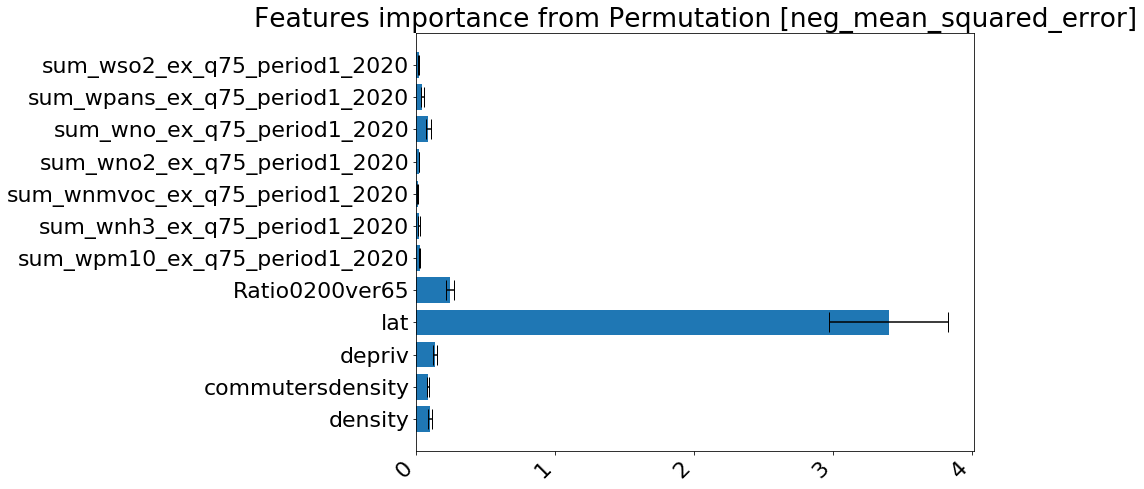

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Score r2: 
Feature:                        density, Score: 0.04506 +/- 0.00563
Feature:               commutersdensity, Score: 0.03857 +/- 0.00481
Feature:                         depriv, Score: 0.06149 +/- 0.00509
Feature:                            lat, Score: 1.55612 +/- 0.19516
Feature:                 Ratio0200ver65, Score: 0.11110 +/- 0.01289
Feature:  sum_wpm10_ex_q75_period1_2020, Score: 0.01100 +/- 0.00153
Feature:   sum_wnh3_ex_q75_period1_2020, Score: 0.00862 +/- 0.00206
Feature: sum_wnmvoc_ex_q75_period1_2020, Score: 0.00492 +/- 0.00108
Feature:   sum_wno2_ex_q75_period1_2020, Score: 0.00883 +/- 0.00124
Feature:    sum_wno_ex_q75_period1_2020, Score: 0.03919 +/- 0.00765
Feature:  sum_wpans_ex_q75_period1_2020, Score: 0.01964 +/- 0.00417
Feature:   sum_wso2_ex_q75_period1_2020, Score: 0.00757 +/- 0.00131


<Figure size 432x288 with 0 Axes>

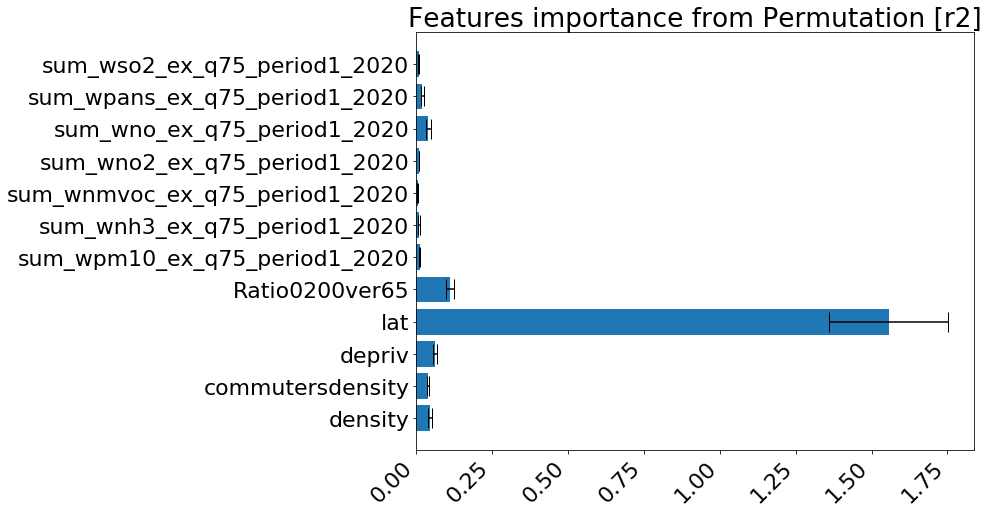

<Figure size 720x720 with 0 Axes>

((0.35034136094902935, 0.020060274464072197),
 (0.9485459192670795, 0.09509583196619786),
 0.3403711148814181,
 {'density': 0.02356331913388712,
  'commutersdensity': 0.020172833389614307,
  'depriv': 0.03215681628095861,
  'lat': 0.8138230717930148,
  'Ratio0200ver65': 0.05810124110630728,
  'sum_wpm10_ex_q75_period1_2020': 0.005753479198603926,
  'sum_wnh3_ex_q75_period1_2020': 0.004507888020677291,
  'sum_wnmvoc_ex_q75_period1_2020': 0.002571324485090865,
  'sum_wno2_ex_q75_period1_2020': 0.00461976160486854,
  'sum_wno_ex_q75_period1_2020': 0.0204965201320259,
  'sum_wpans_ex_q75_period1_2020': 0.010272387367527995,
  'sum_wso2_ex_q75_period1_2020': 0.003961357487423069},
 {'density': 0.02356331913388714,
  'commutersdensity': 0.02017283338961433,
  'depriv': 0.032156816280958636,
  'lat': 0.8138230717930147,
  'Ratio0200ver65': 0.058101241106307315,
  'sum_wpm10_ex_q75_period1_2020': 0.0057534791986039524,
  'sum_wnh3_ex_q75_period1_2020': 0.004507888020677318,
  'sum_wnmvoc_ex_q7

In [7]:
pprint(bestf)

featuresused = features

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

plt.figure(figsize=(10,10))
smlmodule.rfregressors (X, Y , featuresused, N=50, pout=sys.stdout, plotname="rf_model_allfeatures_opt_using_sum",showplot=True, optimisedparams=bestf)

Training set average RMSE:  0.38582  0.02859 
    Test set average RMSE:  1.04991  0.10117 
Parameters used: 
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}
             Fullset RMSE:  0.36787
                       R2:  0.93807


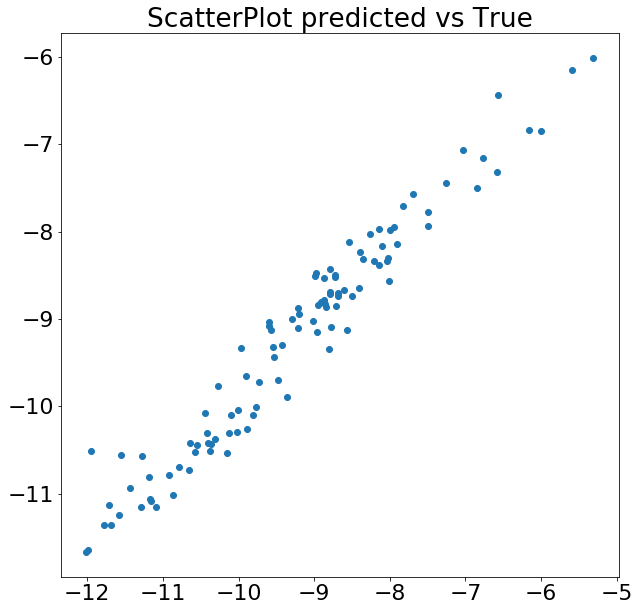

<Figure size 720x720 with 0 Axes>


Features importance from model: 
Feature:                        density, Score: 0.07031
Feature:               commutersdensity, Score: 0.50688
Feature:                         depriv, Score: 0.09051
Feature:                 Ratio0200ver65, Score: 0.13006
Feature:  sum_wpm10_ex_q75_period1_2020, Score: 0.01834
Feature:   sum_wnh3_ex_q75_period1_2020, Score: 0.02585
Feature: sum_wnmvoc_ex_q75_period1_2020, Score: 0.04959
Feature:   sum_wno2_ex_q75_period1_2020, Score: 0.04208
Feature:    sum_wno_ex_q75_period1_2020, Score: 0.02486
Feature:  sum_wpans_ex_q75_period1_2020, Score: 0.02497
Feature:   sum_wso2_ex_q75_period1_2020, Score: 0.01654


<Figure size 432x288 with 0 Axes>

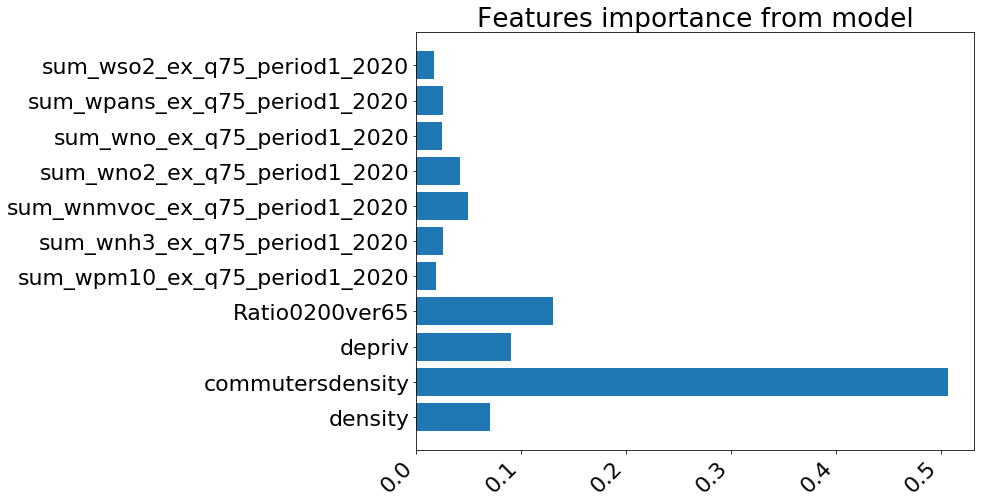

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Score neg_mean_squared_error : 
Feature:                        density, Score: 0.16312 +/- 0.02148
Feature:               commutersdensity, Score: 1.75801 +/- 0.21237
Feature:                         depriv, Score: 0.23573 +/- 0.02605
Feature:                 Ratio0200ver65, Score: 0.35523 +/- 0.03883
Feature:  sum_wpm10_ex_q75_period1_2020, Score: 0.03577 +/- 0.00576
Feature:   sum_wnh3_ex_q75_period1_2020, Score: 0.06005 +/- 0.01233
Feature: sum_wnmvoc_ex_q75_period1_2020, Score: 0.03776 +/- 0.00844
Feature:   sum_wno2_ex_q75_period1_2020, Score: 0.11401 +/- 0.01695
Feature:    sum_wno_ex_q75_period1_2020, Score: 0.06275 +/- 0.01314
Feature:  sum_wpans_ex_q75_period1_2020, Score: 0.04890 +/- 0.00929
Feature:   sum_wso2_ex_q75_period1_2020, Score: 0.03643 +/- 0.00773


<Figure size 432x288 with 0 Axes>

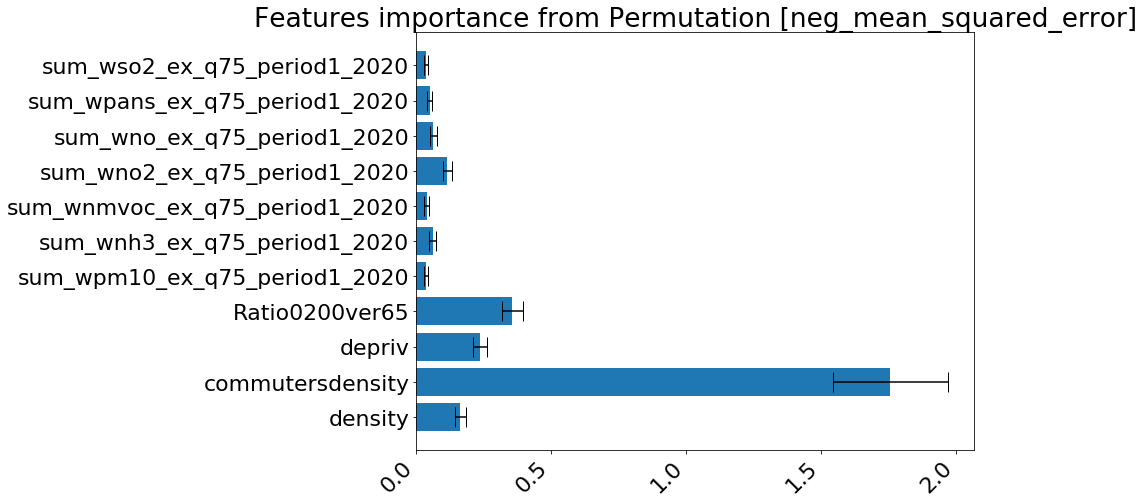

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Score r2: 
Feature:                        density, Score: 0.07465 +/- 0.00983
Feature:               commutersdensity, Score: 0.80449 +/- 0.09718
Feature:                         depriv, Score: 0.10787 +/- 0.01192
Feature:                 Ratio0200ver65, Score: 0.16256 +/- 0.01777
Feature:  sum_wpm10_ex_q75_period1_2020, Score: 0.01637 +/- 0.00263
Feature:   sum_wnh3_ex_q75_period1_2020, Score: 0.02748 +/- 0.00564
Feature: sum_wnmvoc_ex_q75_period1_2020, Score: 0.01728 +/- 0.00386
Feature:   sum_wno2_ex_q75_period1_2020, Score: 0.05217 +/- 0.00776
Feature:    sum_wno_ex_q75_period1_2020, Score: 0.02871 +/- 0.00601
Feature:  sum_wpans_ex_q75_period1_2020, Score: 0.02238 +/- 0.00425
Feature:   sum_wso2_ex_q75_period1_2020, Score: 0.01667 +/- 0.00354


<Figure size 432x288 with 0 Axes>

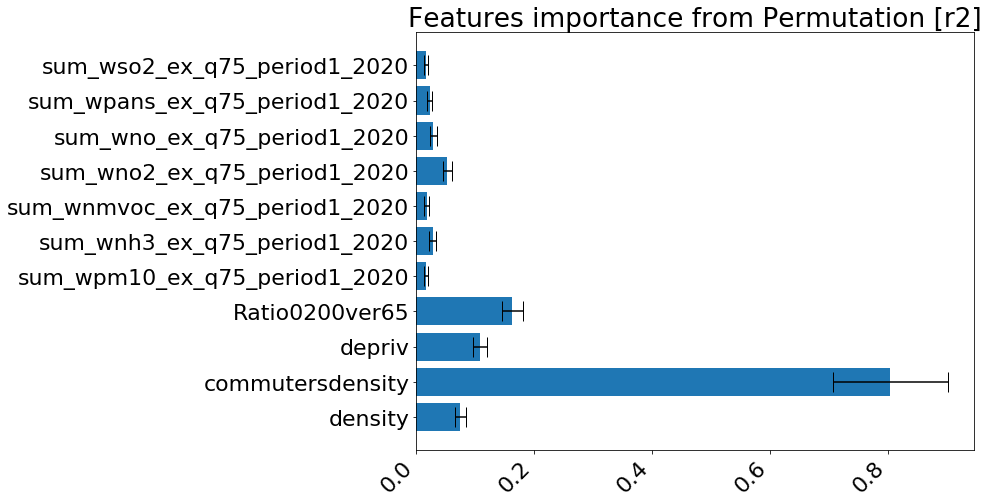

<Figure size 720x720 with 0 Axes>

((0.3858215135527977, 0.028590103876672292),
 (1.0499143099102093, 0.10117197251606615),
 0.36786512964262175,
 {'density': 0.056099643637085486,
  'commutersdensity': 0.6045901684108373,
  'depriv': 0.08106946288260158,
  'Ratio0200ver65': 0.12216729759063816,
  'sum_wpm10_ex_q75_period1_2020': 0.012301503365958309,
  'sum_wnh3_ex_q75_period1_2020': 0.02065038606322205,
  'sum_wnmvoc_ex_q75_period1_2020': 0.012987254241924574,
  'sum_wno2_ex_q75_period1_2020': 0.03920931510173196,
  'sum_wno_ex_q75_period1_2020': 0.021579921299700197,
  'sum_wpans_ex_q75_period1_2020': 0.01681698240512629,
  'sum_wso2_ex_q75_period1_2020': 0.012528065001174123},
 {'density': 0.056099643637085486,
  'commutersdensity': 0.6045901684108376,
  'depriv': 0.08106946288260161,
  'Ratio0200ver65': 0.12216729759063814,
  'sum_wpm10_ex_q75_period1_2020': 0.01230150336595829,
  'sum_wnh3_ex_q75_period1_2020': 0.020650386063222028,
  'sum_wnmvoc_ex_q75_period1_2020': 0.012987254241924555,
  'sum_wno2_ex_q75_perio

In [8]:
importlib.reload(smlmodule)

featuresused = []

for f in features:
    if f != "lat":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

plt.figure(figsize=(10,10))
smlmodule.rfregressors (X, Y , featuresused, N=50, plotname="rf_model_nolat_using_sum", pout=sys.stdout, showplot=True)

In [9]:
importlib.reload(smlmodule)

featuresused = []

for f in features:
    if f != "lat":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack(listostack)
Y = np.asanyarray(ylogpropcasi)

bestf, bestmse = smlmodule.rfregressors_custom_optimizer (X, Y, inboot=[True])

print(bestf, bestmse)

1  of  1200 MSE:  0.1353247536069829
2  of  1200 MSE:  0.1334775836590861
3  of  1200 MSE:  0.23528894367080994
4  of  1200 MSE:  0.31783393345015126
5  of  1200 MSE:  0.5356842893054754
6  of  1200 MSE:  0.6378610816745572
7  of  1200 MSE:  0.7679866092546285
8  of  1200 MSE:  0.8167981956796336
9  of  1200 MSE:  0.2174267708021265
10  of  1200 MSE:  0.2836691300827924
11  of  1200 MSE:  0.2603865018737394
12  of  1200 MSE:  0.3726843470320694
13  of  1200 MSE:  0.5356842893054754
14  of  1200 MSE:  0.6378610816745572
15  of  1200 MSE:  0.7679866092546285
16  of  1200 MSE:  0.8167981956796336
17  of  1200 MSE:  0.3865664481922113
18  of  1200 MSE:  0.4669391542616401
19  of  1200 MSE:  0.4104208956993421
20  of  1200 MSE:  0.5249875358913297
21  of  1200 MSE:  0.5356842893054754
22  of  1200 MSE:  0.6378610816745572
23  of  1200 MSE:  0.7679866092546285
24  of  1200 MSE:  0.8167981956796336
25  of  1200 MSE:  0.5130428673366582
26  of  1200 MSE:  0.6072292493222795
27  of  1200 MSE:  

Training set average RMSE:  0.37158  0.02189 
    Test set average RMSE:  0.99834  0.11523 
Parameters used: 
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 1200,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}
             Fullset RMSE:  0.35680
                       R2:  0.94174


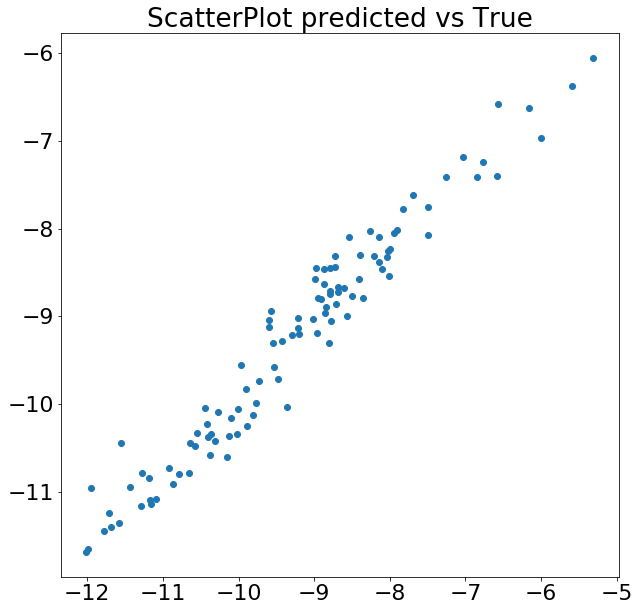

<Figure size 720x720 with 0 Axes>


Features importance from model: 
Feature:                        density, Score: 0.07978
Feature:               commutersdensity, Score: 0.23958
Feature:                         depriv, Score: 0.14272
Feature:                 Ratio0200ver65, Score: 0.10516
Feature:  sum_wpm10_ex_q75_period1_2020, Score: 0.05891
Feature:   sum_wnh3_ex_q75_period1_2020, Score: 0.09301
Feature: sum_wnmvoc_ex_q75_period1_2020, Score: 0.09152
Feature:   sum_wno2_ex_q75_period1_2020, Score: 0.10977
Feature:    sum_wno_ex_q75_period1_2020, Score: 0.02007
Feature:  sum_wpans_ex_q75_period1_2020, Score: 0.03020
Feature:   sum_wso2_ex_q75_period1_2020, Score: 0.02928


<Figure size 432x288 with 0 Axes>

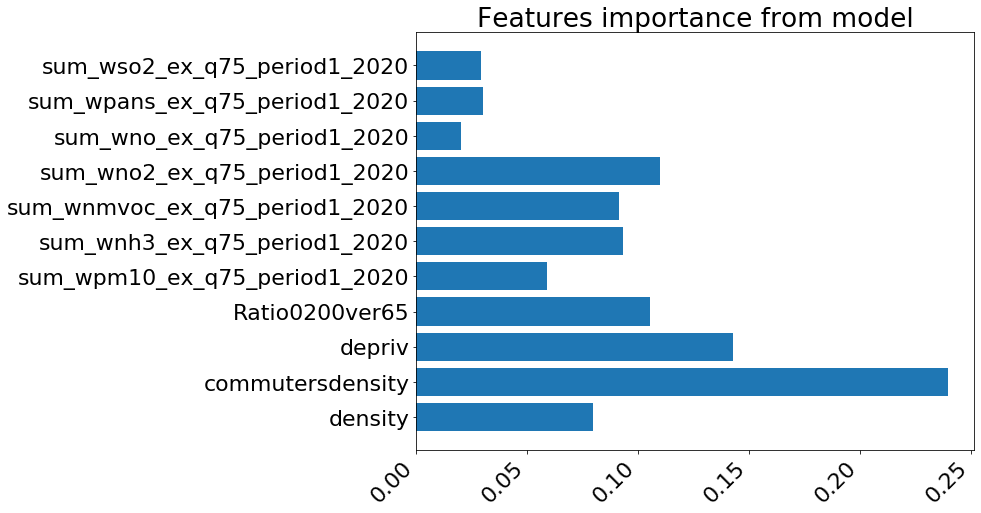

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Score neg_mean_squared_error : 
Feature:                        density, Score: 0.18262 +/- 0.02366
Feature:               commutersdensity, Score: 1.89784 +/- 0.23211
Feature:                         depriv, Score: 0.20459 +/- 0.02255
Feature:                 Ratio0200ver65, Score: 0.36292 +/- 0.04219
Feature:  sum_wpm10_ex_q75_period1_2020, Score: 0.02935 +/- 0.00558
Feature:   sum_wnh3_ex_q75_period1_2020, Score: 0.06555 +/- 0.01313
Feature: sum_wnmvoc_ex_q75_period1_2020, Score: 0.03399 +/- 0.00700
Feature:   sum_wno2_ex_q75_period1_2020, Score: 0.09439 +/- 0.01411
Feature:    sum_wno_ex_q75_period1_2020, Score: 0.05289 +/- 0.01309
Feature:  sum_wpans_ex_q75_period1_2020, Score: 0.06491 +/- 0.01102
Feature:   sum_wso2_ex_q75_period1_2020, Score: 0.03242 +/- 0.00762


<Figure size 432x288 with 0 Axes>

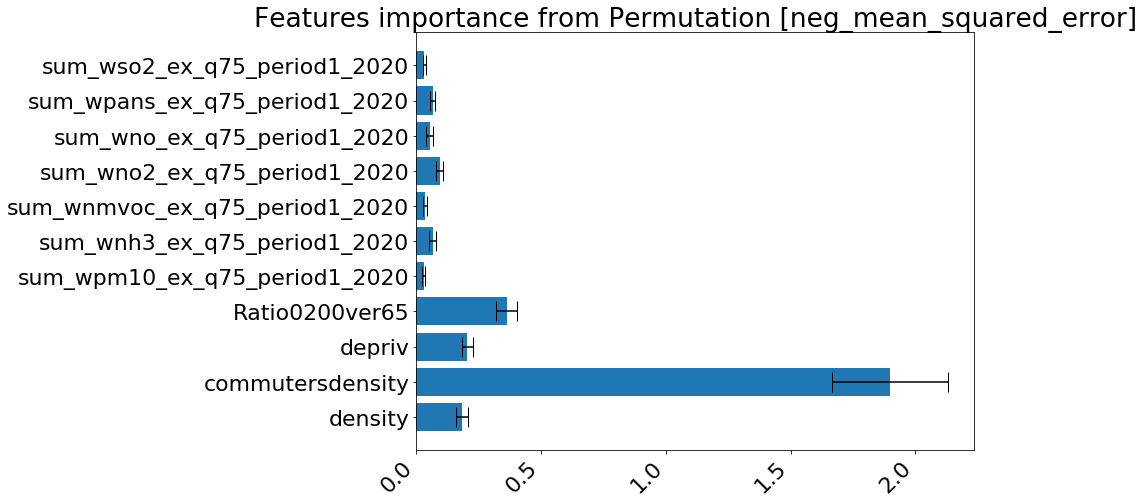

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Score r2: 
Feature:                        density, Score: 0.08357 +/- 0.01083
Feature:               commutersdensity, Score: 0.86848 +/- 0.10621
Feature:                         depriv, Score: 0.09362 +/- 0.01032
Feature:                 Ratio0200ver65, Score: 0.16608 +/- 0.01931
Feature:  sum_wpm10_ex_q75_period1_2020, Score: 0.01343 +/- 0.00256
Feature:   sum_wnh3_ex_q75_period1_2020, Score: 0.03000 +/- 0.00601
Feature: sum_wnmvoc_ex_q75_period1_2020, Score: 0.01555 +/- 0.00321
Feature:   sum_wno2_ex_q75_period1_2020, Score: 0.04320 +/- 0.00646
Feature:    sum_wno_ex_q75_period1_2020, Score: 0.02420 +/- 0.00599
Feature:  sum_wpans_ex_q75_period1_2020, Score: 0.02970 +/- 0.00504
Feature:   sum_wso2_ex_q75_period1_2020, Score: 0.01484 +/- 0.00349


<Figure size 432x288 with 0 Axes>

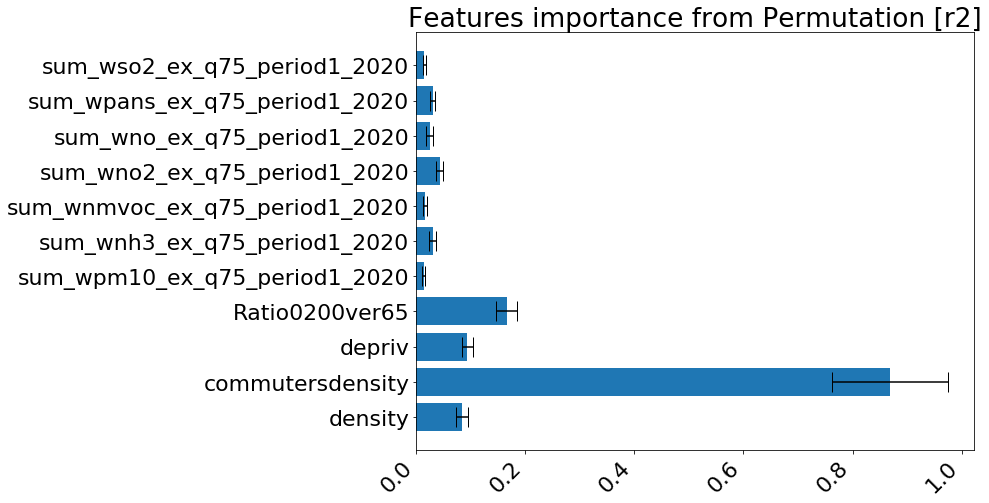

<Figure size 720x720 with 0 Axes>

((0.37158374919230985, 0.021889513506449725),
 (0.9983375080724486, 0.11522962666761964),
 0.3568007410765382,
 {'density': 0.06044200766578632,
  'commutersdensity': 0.6281135970467012,
  'depriv': 0.0677124932459678,
  'Ratio0200ver65': 0.12011247285311041,
  'sum_wpm10_ex_q75_period1_2020': 0.00971527630059561,
  'sum_wnh3_ex_q75_period1_2020': 0.0216953670355789,
  'sum_wnmvoc_ex_q75_period1_2020': 0.011249590409952805,
  'sum_wno2_ex_q75_period1_2020': 0.031240833926317286,
  'sum_wno_ex_q75_period1_2020': 0.017504639118184007,
  'sum_wpans_ex_q75_period1_2020': 0.021483121799119036,
  'sum_wso2_ex_q75_period1_2020': 0.010730600598686727},
 {'density': 0.06044200766578632,
  'commutersdensity': 0.6281135970467011,
  'depriv': 0.0677124932459678,
  'Ratio0200ver65': 0.12011247285311041,
  'sum_wpm10_ex_q75_period1_2020': 0.009715276300595635,
  'sum_wnh3_ex_q75_period1_2020': 0.02169536703557891,
  'sum_wnmvoc_ex_q75_period1_2020': 0.011249590409952827,
  'sum_wno2_ex_q75_period1_2

In [10]:
importlib.reload(smlmodule)

featuresused = []

for f in features:
    if f != "lat":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

plt.figure(figsize=(10,10))
smlmodule.rfregressors (X, Y , featuresused, N=50, pout=sys.stdout, plotname="rf_model_nolat_opt_using_sum", showplot=True, optimisedparams=bestf)

Training set average RMSE:  0.40016  0.03278 
    Test set average RMSE:  1.07739  0.12633 
Parameters used: 
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}
             Fullset RMSE:  0.37683
                       R2:  0.93502


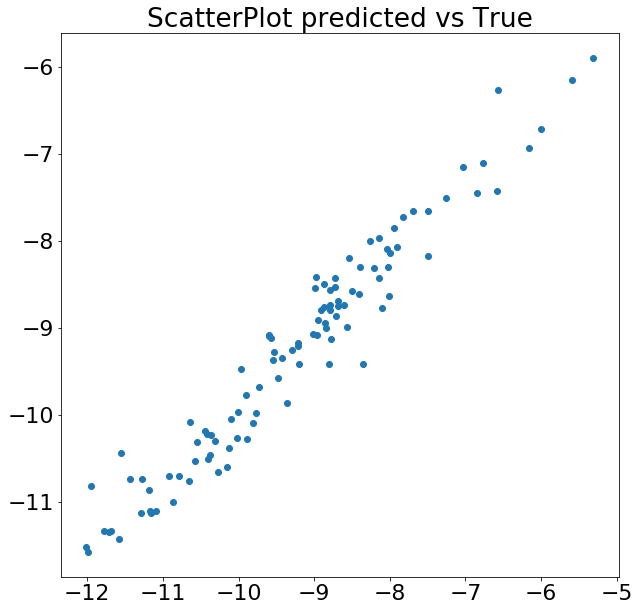

<Figure size 720x720 with 0 Axes>


Features importance from model: 
Feature:                        density, Score: 0.09314
Feature:                         depriv, Score: 0.23247
Feature:                 Ratio0200ver65, Score: 0.14088
Feature:  sum_wpm10_ex_q75_period1_2020, Score: 0.02239
Feature:   sum_wnh3_ex_q75_period1_2020, Score: 0.16012
Feature: sum_wnmvoc_ex_q75_period1_2020, Score: 0.09254
Feature:   sum_wno2_ex_q75_period1_2020, Score: 0.18353
Feature:    sum_wno_ex_q75_period1_2020, Score: 0.01694
Feature:  sum_wpans_ex_q75_period1_2020, Score: 0.02520
Feature:   sum_wso2_ex_q75_period1_2020, Score: 0.03278


<Figure size 432x288 with 0 Axes>

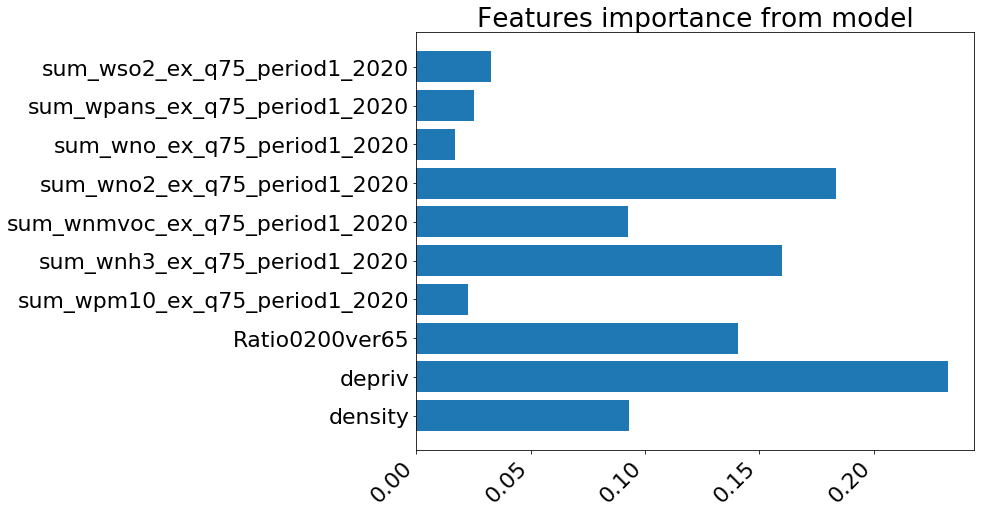

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Score neg_mean_squared_error : 
Feature:                        density, Score: 0.19007 +/- 0.02133
Feature:                         depriv, Score: 0.43002 +/- 0.04036
Feature:                 Ratio0200ver65, Score: 0.37801 +/- 0.04123
Feature:  sum_wpm10_ex_q75_period1_2020, Score: 0.03418 +/- 0.00633
Feature:   sum_wnh3_ex_q75_period1_2020, Score: 0.53605 +/- 0.07395
Feature: sum_wnmvoc_ex_q75_period1_2020, Score: 0.12666 +/- 0.02329
Feature:   sum_wno2_ex_q75_period1_2020, Score: 0.43523 +/- 0.05740
Feature:    sum_wno_ex_q75_period1_2020, Score: 0.04567 +/- 0.00885
Feature:  sum_wpans_ex_q75_period1_2020, Score: 0.06164 +/- 0.00836
Feature:   sum_wso2_ex_q75_period1_2020, Score: 0.09706 +/- 0.01846


<Figure size 432x288 with 0 Axes>

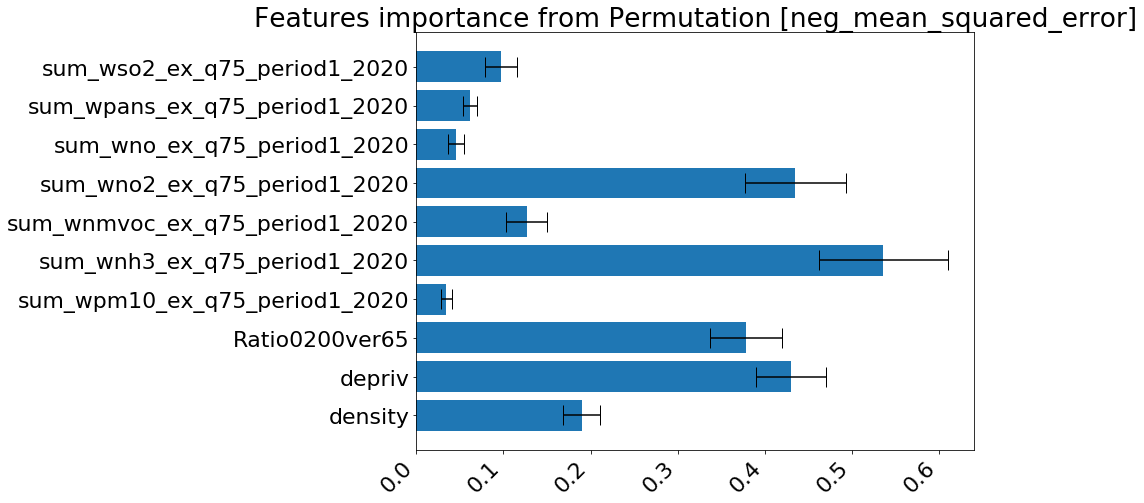

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Score r2: 
Feature:                        density, Score: 0.08698 +/- 0.00976
Feature:                         depriv, Score: 0.19678 +/- 0.01847
Feature:                 Ratio0200ver65, Score: 0.17298 +/- 0.01887
Feature:  sum_wpm10_ex_q75_period1_2020, Score: 0.01564 +/- 0.00290
Feature:   sum_wnh3_ex_q75_period1_2020, Score: 0.24530 +/- 0.03384
Feature: sum_wnmvoc_ex_q75_period1_2020, Score: 0.05796 +/- 0.01066
Feature:   sum_wno2_ex_q75_period1_2020, Score: 0.19917 +/- 0.02627
Feature:    sum_wno_ex_q75_period1_2020, Score: 0.02090 +/- 0.00405
Feature:  sum_wpans_ex_q75_period1_2020, Score: 0.02821 +/- 0.00382
Feature:   sum_wso2_ex_q75_period1_2020, Score: 0.04441 +/- 0.00845


<Figure size 432x288 with 0 Axes>

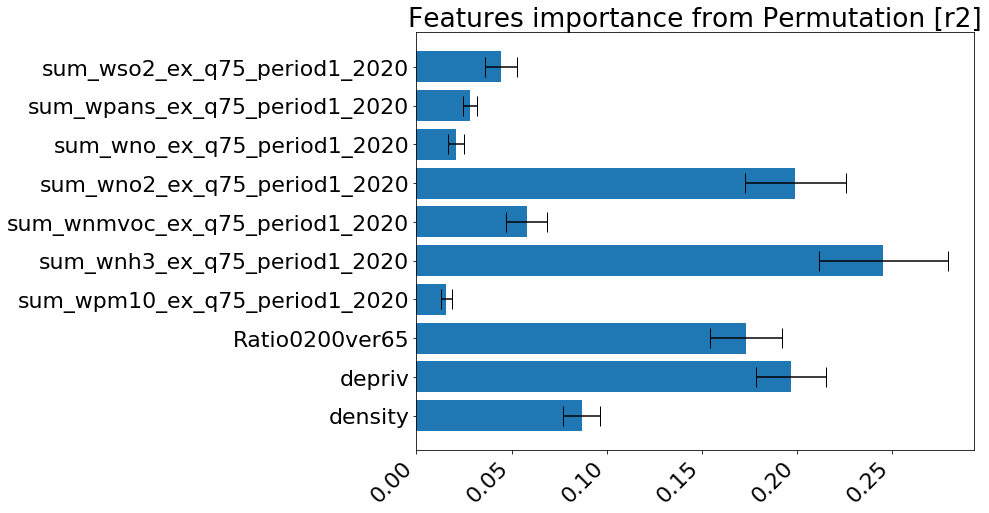

<Figure size 720x720 with 0 Axes>

((0.40015826434857943, 0.03278085462743031),
 (1.0773889817944526, 0.12632607158536957),
 0.3768304329919168,
 {'density': 0.08141493070613791,
  'depriv': 0.18419470533262589,
  'Ratio0200ver65': 0.16192022618440974,
  'sum_wpm10_ex_q75_period1_2020': 0.014641174882768603,
  'sum_wnh3_ex_q75_period1_2020': 0.22961352934228263,
  'sum_wnmvoc_ex_q75_period1_2020': 0.05425220600759812,
  'sum_wno2_ex_q75_period1_2020': 0.1864282351985896,
  'sum_wno_ex_q75_period1_2020': 0.019560734372603476,
  'sum_wpans_ex_q75_period1_2020': 0.026401213255446296,
  'sum_wso2_ex_q75_period1_2020': 0.04157304471753771},
 {'density': 0.08141493070613792,
  'depriv': 0.18419470533262586,
  'Ratio0200ver65': 0.16192022618440977,
  'sum_wpm10_ex_q75_period1_2020': 0.014641174882768603,
  'sum_wnh3_ex_q75_period1_2020': 0.22961352934228263,
  'sum_wnmvoc_ex_q75_period1_2020': 0.054252206007598135,
  'sum_wno2_ex_q75_period1_2020': 0.18642823519858956,
  'sum_wno_ex_q75_period1_2020': 0.01956073437260348,
  's

In [11]:
importlib.reload(smlmodule)

featuresused = []

for f in features:
    if f != "lat" and f != "commutersdensity":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

plt.figure(figsize=(10,10))
smlmodule.rfregressors (X, Y , featuresused, N=50, plotname="rf_model_nolat_nocom_using_sum", pout=sys.stdout, showplot=True)

In [12]:
importlib.reload(smlmodule)

featuresused = []

for f in features:
    if f != "lat" and f != "commutersdensity":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack(listostack)
Y = np.asanyarray(ylogpropcasi)

bestf, bestmse = smlmodule.rfregressors_custom_optimizer (X, Y, inboot=[True])

print(bestf, bestmse)

1  of  1200 MSE:  0.1420011752288755
2  of  1200 MSE:  0.13944724714137738
3  of  1200 MSE:  0.2612335259385352
4  of  1200 MSE:  0.3597857645332215
5  of  1200 MSE:  0.5909089538659124
6  of  1200 MSE:  0.7207469493897016
7  of  1200 MSE:  0.8250122845974273
8  of  1200 MSE:  0.905843137753508
9  of  1200 MSE:  0.23278633121520378
10  of  1200 MSE:  0.3149146450790248
11  of  1200 MSE:  0.2913103424252448
12  of  1200 MSE:  0.3960381380316058
13  of  1200 MSE:  0.5909089538659124
14  of  1200 MSE:  0.7207469493897016
15  of  1200 MSE:  0.8250122845974273
16  of  1200 MSE:  0.905843137753508
17  of  1200 MSE:  0.396467567077844
18  of  1200 MSE:  0.5048195018741446
19  of  1200 MSE:  0.43923165547026394
20  of  1200 MSE:  0.5582078262323665
21  of  1200 MSE:  0.5909089538659124
22  of  1200 MSE:  0.7207469493897016
23  of  1200 MSE:  0.8250122845974273
24  of  1200 MSE:  0.905843137753508
25  of  1200 MSE:  0.5548673069190992
26  of  1200 MSE:  0.6421250160635305
27  of  1200 MSE:  0.5

Training set average RMSE:  0.37484  0.02756 
    Test set average RMSE:  1.03867  0.11014 
Parameters used: 
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 1200,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}
             Fullset RMSE:  0.36129
                       R2:  0.94027


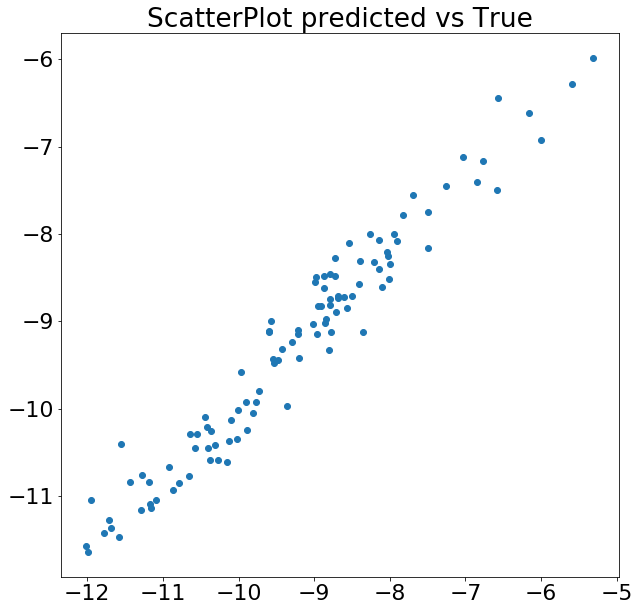

<Figure size 720x720 with 0 Axes>


Features importance from model: 
Feature:                        density, Score: 0.10752
Feature:                         depriv, Score: 0.20219
Feature:                 Ratio0200ver65, Score: 0.12657
Feature:  sum_wpm10_ex_q75_period1_2020, Score: 0.06965
Feature:   sum_wnh3_ex_q75_period1_2020, Score: 0.11694
Feature: sum_wnmvoc_ex_q75_period1_2020, Score: 0.11545
Feature:   sum_wno2_ex_q75_period1_2020, Score: 0.16614
Feature:    sum_wno_ex_q75_period1_2020, Score: 0.02003
Feature:  sum_wpans_ex_q75_period1_2020, Score: 0.03661
Feature:   sum_wso2_ex_q75_period1_2020, Score: 0.03889


<Figure size 432x288 with 0 Axes>

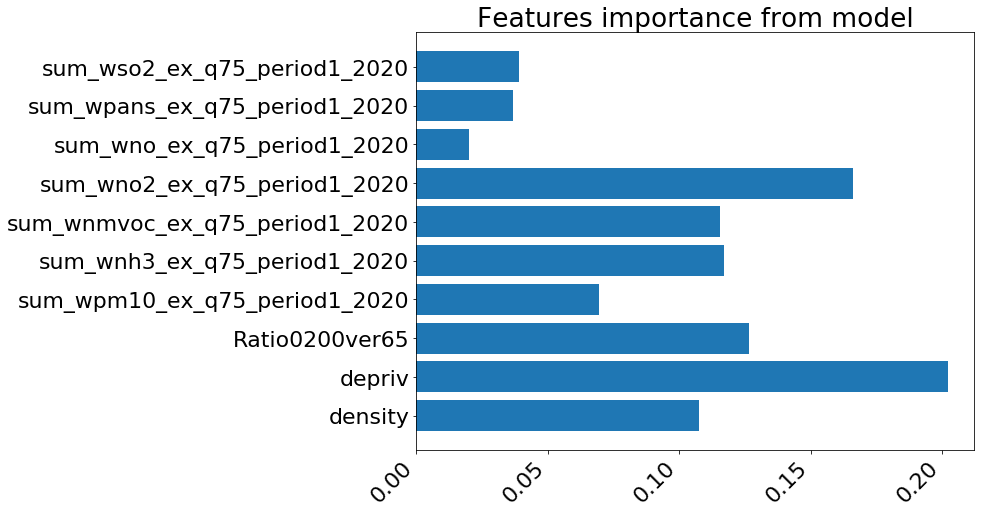

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Score neg_mean_squared_error : 
Feature:                        density, Score: 0.20450 +/- 0.02340
Feature:                         depriv, Score: 0.44785 +/- 0.03855
Feature:                 Ratio0200ver65, Score: 0.35213 +/- 0.04303
Feature:  sum_wpm10_ex_q75_period1_2020, Score: 0.04431 +/- 0.00760
Feature:   sum_wnh3_ex_q75_period1_2020, Score: 0.56564 +/- 0.07617
Feature: sum_wnmvoc_ex_q75_period1_2020, Score: 0.19043 +/- 0.03330
Feature:   sum_wno2_ex_q75_period1_2020, Score: 0.43043 +/- 0.05377
Feature:    sum_wno_ex_q75_period1_2020, Score: 0.03122 +/- 0.00622
Feature:  sum_wpans_ex_q75_period1_2020, Score: 0.06256 +/- 0.00868
Feature:   sum_wso2_ex_q75_period1_2020, Score: 0.06666 +/- 0.01149


<Figure size 432x288 with 0 Axes>

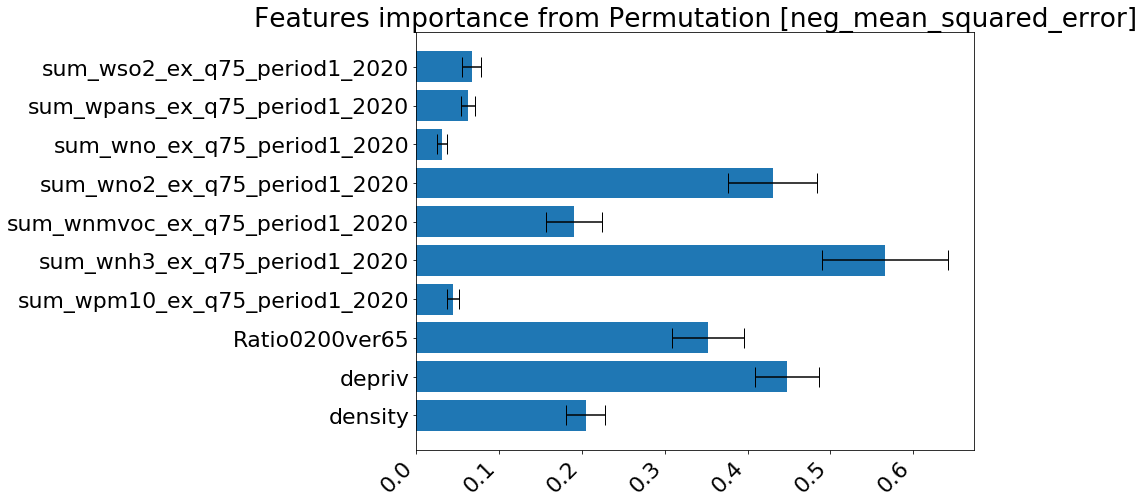

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Score r2: 
Feature:                        density, Score: 0.09358 +/- 0.01071
Feature:                         depriv, Score: 0.20494 +/- 0.01764
Feature:                 Ratio0200ver65, Score: 0.16114 +/- 0.01969
Feature:  sum_wpm10_ex_q75_period1_2020, Score: 0.02028 +/- 0.00348
Feature:   sum_wnh3_ex_q75_period1_2020, Score: 0.25885 +/- 0.03486
Feature: sum_wnmvoc_ex_q75_period1_2020, Score: 0.08714 +/- 0.01524
Feature:   sum_wno2_ex_q75_period1_2020, Score: 0.19697 +/- 0.02460
Feature:    sum_wno_ex_q75_period1_2020, Score: 0.01429 +/- 0.00284
Feature:  sum_wpans_ex_q75_period1_2020, Score: 0.02863 +/- 0.00397
Feature:   sum_wso2_ex_q75_period1_2020, Score: 0.03050 +/- 0.00526


<Figure size 432x288 with 0 Axes>

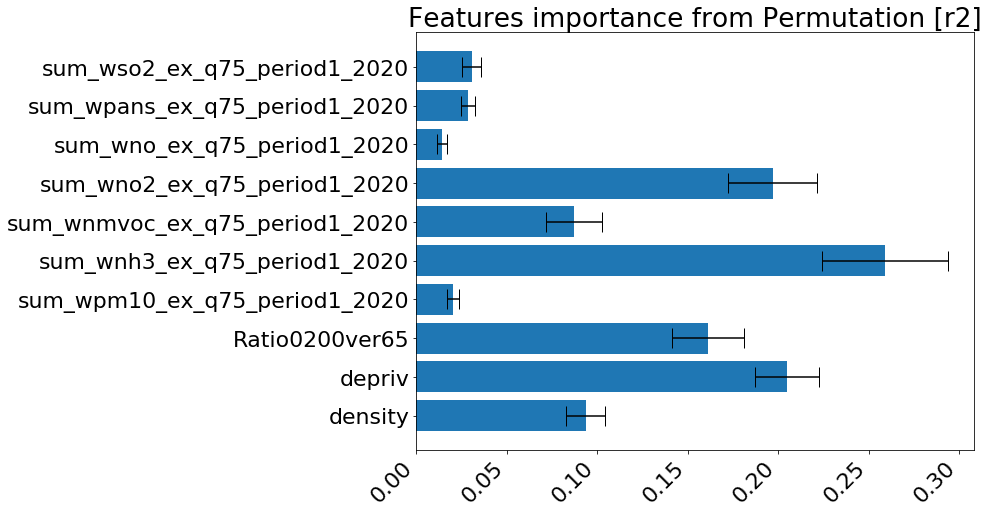

<Figure size 720x720 with 0 Axes>

((0.37484212076079815, 0.027555423863910168),
 (1.038673458204406, 0.11013762621938028),
 0.36128980005633254,
 {'density': 0.08535899668249883,
  'depriv': 0.18693769005098684,
  'Ratio0200ver65': 0.14698177107721344,
  'sum_wpm10_ex_q75_period1_2020': 0.018495969607814355,
  'sum_wnh3_ex_q75_period1_2020': 0.23610530762507115,
  'sum_wnmvoc_ex_q75_period1_2020': 0.07948671486033568,
  'sum_wno2_ex_q75_period1_2020': 0.17966411365276633,
  'sum_wno_ex_q75_period1_2020': 0.013031723420530153,
  'sum_wpans_ex_q75_period1_2020': 0.026112968906511883,
  'sum_wso2_ex_q75_period1_2020': 0.02782474411627138},
 {'density': 0.08535899668249883,
  'depriv': 0.1869376900509868,
  'Ratio0200ver65': 0.14698177107721347,
  'sum_wpm10_ex_q75_period1_2020': 0.01849596960781437,
  'sum_wnh3_ex_q75_period1_2020': 0.23610530762507104,
  'sum_wnmvoc_ex_q75_period1_2020': 0.07948671486033568,
  'sum_wno2_ex_q75_period1_2020': 0.17966411365276633,
  'sum_wno_ex_q75_period1_2020': 0.01303172342053016,
  'su

In [13]:
importlib.reload(smlmodule)

featuresused = []

for f in features:
    if f != "lat" and f != "commutersdensity":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

plt.figure(figsize=(10,10))
smlmodule.rfregressors (X, Y , featuresused, N=50, pout=sys.stdout, plotname="rf_model_nolat_nocom_opt_using_sum", showplot=True, optimisedparams=bestf)